In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, plot_confusion_matrix
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive') # library to read file in google drive

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/transaction_dataset.csv') 
df = df.dropna()
print(df)
df.head 

      Unnamed: 0  Index                                     Address  FLAG  \
0              0      1  0x00009277775ac7d0d59eaad8fee3d10ac6c805e8     0   
1              1      2  0x0002b44ddb1476db43c868bd494422ee4c136fed     0   
2              2      3  0x0002bda54cb772d040f779e88eb453cac0daa244     0   
3              3      4  0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e     0   
4              4      5  0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89     0   
...          ...    ...                                         ...   ...   
9832        9832   2171  0xfea28ca175a80f5a348016583961f63be8605f80     1   
9836        9836   2175  0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2     1   
9837        9837   2176  0xff718805bb9199ebf024ab6acd333e603ad77c85     1   
9838        9838   2177  0xff8e6af02d41a576a0c82f7835535193e1a6bccc     1   
9840        9840   2179  0xd624d046edbdef805c5e4140dce5fb5ec1b39a3c     1   

      Avg min between sent tnx  Avg min between received tnx  \
0          

<bound method NDFrame.head of       Unnamed: 0  Index                                     Address  FLAG  \
0              0      1  0x00009277775ac7d0d59eaad8fee3d10ac6c805e8     0   
1              1      2  0x0002b44ddb1476db43c868bd494422ee4c136fed     0   
2              2      3  0x0002bda54cb772d040f779e88eb453cac0daa244     0   
3              3      4  0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e     0   
4              4      5  0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89     0   
...          ...    ...                                         ...   ...   
9832        9832   2171  0xfea28ca175a80f5a348016583961f63be8605f80     1   
9836        9836   2175  0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2     1   
9837        9837   2176  0xff718805bb9199ebf024ab6acd333e603ad77c85     1   
9838        9838   2177  0xff8e6af02d41a576a0c82f7835535193e1a6bccc     1   
9840        9840   2179  0xd624d046edbdef805c5e4140dce5fb5ec1b39a3c     1   

      Avg min between sent tnx  Avg min betwe

In [4]:
# Ommit first two columns (Index, Adress)
df = df.iloc[:,2:]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8981 entries, 0 to 9840
Data columns (total 49 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Address                                               8981 non-null   object 
 1   FLAG                                                  8981 non-null   int64  
 2   Avg min between sent tnx                              8981 non-null   float64
 3   Avg min between received tnx                          8981 non-null   float64
 4   Time Diff between first and last (Mins)               8981 non-null   float64
 5   Sent tnx                                              8981 non-null   int64  
 6   Received Tnx                                          8981 non-null   int64  
 7   Number of Created Contracts                           8981 non-null   int64  
 8   Unique Received From Addresses                        8981

In [6]:
# Turn object variables into 'category' dtype for more computation efficiency
categories = df.select_dtypes('O').columns.astype('category')
df[categories]

,Address,ERC20 most sent token type,ERC20_most_rec_token_type
0,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,Cofoundit,Numeraire
1,0x0002b44ddb1476db43c868bd494422ee4c136fed,Livepeer Token,Livepeer Token
2,0x0002bda54cb772d040f779e88eb453cac0daa244,None,XENON
3,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,Raiden,XENON
4,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,StatusNetwork,EOS
...,...,...,...
9832,0xfea28ca175a80f5a348016583961f63be8605f80,,Blockwell say NOTSAFU
9836,0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2,,GSENetwork
9837,0xff718805bb9199ebf024ab6acd333e603ad77c85,,Blockwell say NOTSAFU
9838,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,,Free BOB Tokens - BobsRepair.com


In [7]:
# Inspect categoricals features
for i in df[categories].columns:
    print(f'The categorical column -{i}- has -{len(df[i].value_counts())}- unique values')

The categorical column -Address- has -8956- unique values
The categorical column - ERC20 most sent token type- has -305- unique values
The categorical column - ERC20_most_rec_token_type- has -467- unique values


0    7631
1    1350
Name: FLAG, dtype: int64


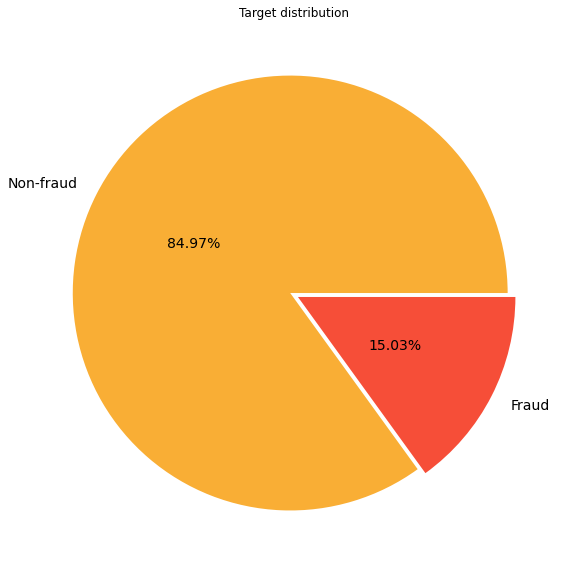

In [8]:
# Inspect target distribution
print(df['FLAG'].value_counts())

pie, ax = plt.subplots(figsize=[15,10])
labels = ['Non-fraud', 'Fraud']
colors = ['#f9ae35', '#f64e38']
plt.pie(x = df['FLAG'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
plt.title('Target distribution')
plt.show()

In [9]:
# Drop the two categorical features
df.drop(df[categories], axis=1, inplace=True)

In [10]:
# Replace missings variables with median
df.fillna(df.median(), inplace=True)

In [11]:
# Filtering features with 0 variance
no_var = df.var() == 0
print(df.var()[no_var])
print('\n')

# Drop features with 0 variance as these features will not help in the performance of the model
df.drop(df.var()[no_var].index, axis = 1, inplace = True)
print(df.var())
print(df.shape)

 ERC20 avg time between sent tnx        0.0
 ERC20 avg time between rec tnx         0.0
 ERC20 avg time between rec 2 tnx       0.0
 ERC20 avg time between contract tnx    0.0
 ERC20 min val sent contract            0.0
 ERC20 max val sent contract            0.0
 ERC20 avg val sent contract            0.0
dtype: float64


FLAG                                                    1.277363e-01
Avg min between sent tnx                                4.905788e+08
Avg min between received tnx                            5.483113e+08
Time Diff between first and last (Mins)                 1.094797e+11
Sent tnx                                                5.919579e+05
Received Tnx                                            9.233123e+05
Number of Created Contracts                             2.192154e+04
Unique Received From Addresses                          9.105151e+04
Unique Sent To Addresses                                6.625338e+04
min value received                                    

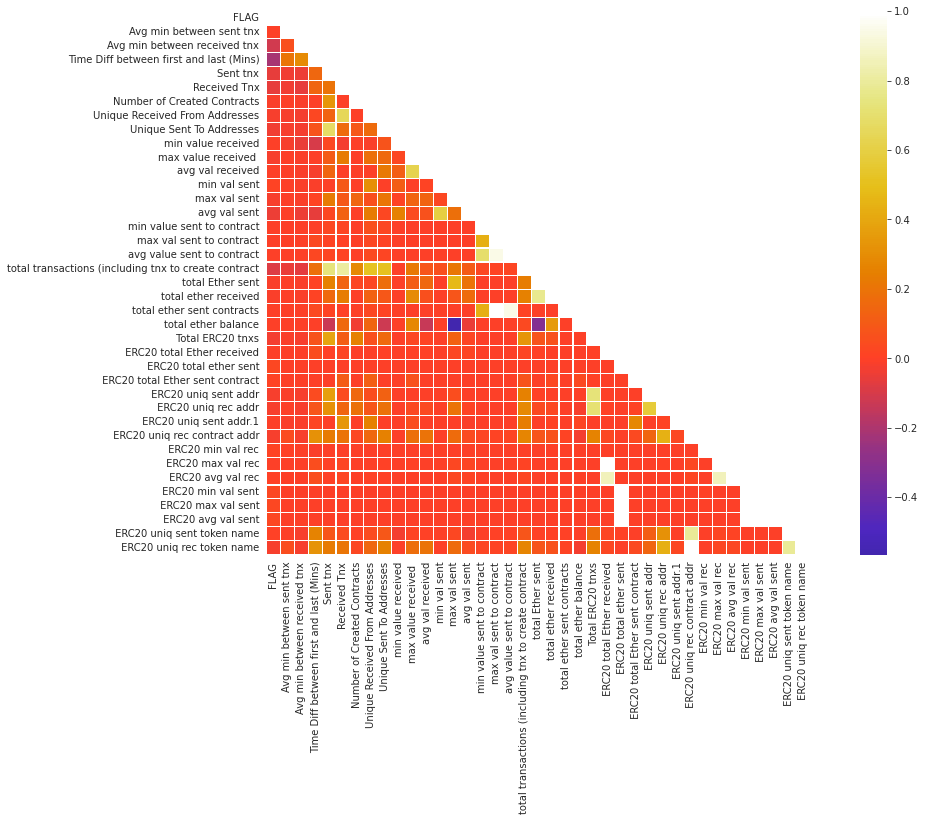

In [12]:
# Checking Correlation matrix

corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, linewidths=0.1, square=True)

In [13]:
#Dropping highly correlated features

drop = ['total transactions (including tnx to create contract', 'total ether sent contracts', 'max val sent to contract', ' ERC20 avg val rec',
        ' ERC20 avg val rec',' ERC20 max val rec', ' ERC20 min val rec', ' ERC20 uniq rec contract addr', 'max val sent', ' ERC20 avg val sent',
        ' ERC20 min val sent', ' ERC20 max val sent', ' Total ERC20 tnxs', 'avg value sent to contract', 'Unique Sent To Addresses',
        'Unique Received From Addresses', 'total ether received', ' ERC20 uniq sent token name', 'min value received', 'min val sent', ' ERC20 uniq rec addr' ]
df.drop(drop, axis=1, inplace=True)

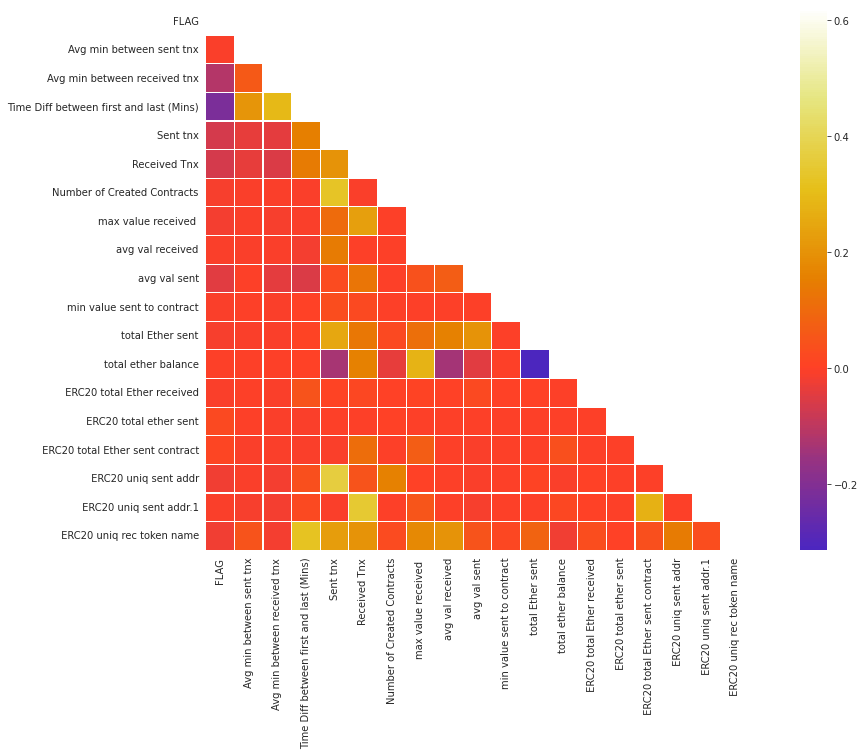

In [14]:
# Rechecking the Correlation matrix
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, linewidths=0.1, square=True)

In [15]:
drops = ['min value sent to contract', ' ERC20 uniq sent addr.1']
df.drop(drops, axis=1, inplace=True)
print(df.shape)
df.head()

(8981, 17)


,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,max value received,avg val received,avg val sent,total Ether sent,total ether balance,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec token name
0,0,844.26,1093.71,704785.63,721,89,0,45.806785,6.589513,1.200681,865.691093,-279.224419,3.558854e+07,3.560317e+07,0.0,30.0,57.0
1,0,12709.07,2958.44,1218216.73,94,8,0,2.613269,0.385685,0.032844,3.087297,-0.001819,4.034283e+02,2.260809e+00,0.0,1.0,7.0
2,0,246194.54,2434.02,516729.30,2,10,0,1.165453,0.358906,1.794308,3.588616,0.000441,5.215121e+02,0.000000e+00,0.0,0.0,8.0
3,0,10219.60,15785.09,397555.90,25,9,0,500.000000,99.488840,70.001834,1750.045862,-854.646303,1.711105e+04,1.141223e+04,0.0,2.0,11.0
4,0,36.61,10707.77,382472.42,4598,20,1,12.802411,2.671095,0.022688,104.318883,-50.896986,1.628297e+05,1.235399e+05,0.0,4.0,27.0


In [16]:
y = df.iloc[:, 0]
X = df.iloc[:, 1:]
print(X.shape, y.shape)

(8981, 16) (8981,)


In [17]:
# Split dataset into training (80%) and testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7184, 16) (7184,)
(1797, 16) (1797,)


In [18]:
# Normalize training features
norm = PowerTransformer()
norm_train_f = norm.fit_transform(X_train)

In [19]:
norm_df = pd.DataFrame(norm_train_f, columns=X_train.columns)
norm_df

,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,max value received,avg val received,avg val sent,total Ether sent,total ether balance,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec token name
0,1.278647,0.719130,1.031930,1.326458,1.198241,-0.390608,-1.116691,-1.205131,-1.011826,-0.178718,-0.005784,-0.780764,-0.427014,-0.040216,-0.453941,-0.924225
1,-1.159648,1.633264,0.766217,-1.473987,-0.435650,2.560000,-0.960778,-0.676972,-1.177712,-1.315830,-0.005774,-0.780764,-0.427014,-0.040216,-0.453941,-0.924225
2,1.160948,0.874287,0.767041,1.287907,0.730608,-0.390608,0.032010,-0.605756,-0.760420,0.195419,-0.005784,1.504450,2.390592,-0.040216,2.335732,1.225879
3,-1.159648,-0.122028,-0.647617,-1.473987,0.484221,-0.390608,-0.652856,-0.625733,-1.177712,-1.315830,-0.005734,1.111180,-0.427014,-0.040216,-0.453941,1.115025
4,0.449944,-1.209905,-0.976692,-0.058566,-1.091228,-0.390608,1.025413,1.384341,1.142736,0.696397,-0.005784,-0.780764,-0.427014,-0.040216,-0.453941,-0.924225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7179,-1.159648,0.492201,0.714556,-1.473987,1.415424,2.560000,-0.925795,-0.898447,-1.177712,-1.315830,-0.005512,-0.058034,-0.427014,-0.040216,-0.453941,0.709654
7180,1.109009,0.708016,0.635494,1.280865,0.820125,-0.390608,0.249299,-0.572428,-0.659907,0.295154,-0.005784,1.458468,-0.427014,-0.040216,-0.453941,1.115025
7181,-0.807964,-0.705518,-1.309648,-0.058566,-0.435650,-0.390608,1.483702,1.514887,1.604508,1.202368,-0.005784,-0.780764,-0.427014,-0.040216,-0.453941,-0.924225
7182,-0.366605,0.459069,0.701598,1.506103,1.439333,-0.390608,-1.441758,-1.281415,-1.094778,-0.229152,-0.005784,-0.780764,-0.427014,-0.040216,-0.453941,-0.924225


In [20]:
#SMOTE method for resampling class imbalance problem
#SMOTE on training set

oversample = SMOTE()
print(f'Shape of the training before SMOTE: {norm_train_f.shape, y_train.shape}')

x_tr_resample, y_tr_resample = oversample.fit_resample(norm_train_f, y_train)
print(f'Shape of the training after SMOTE: {x_tr_resample.shape, y_tr_resample.shape}')

Shape of the training before SMOTE: ((7184, 16), (7184,))
Shape of the training after SMOTE: ((12162, 16), (12162,))


In [21]:
# Target distribution before SMOTE
non_fraud = 0
fraud = 0

for i in y_train:
    if i == 0:
        non_fraud +=1
    else:
        fraud +=1

# Target distribution after SMOTE
no = 0
yes = 1

for j in y_tr_resample:
    if j == 0:
        no +=1
    else:
        yes +=1

print(f'BEFORE OVERSAMPLING \n \tNon-frauds: {non_fraud} \n \tFauds: {fraud}')
print(f'AFTER OVERSAMPLING \n \tNon-frauds: {no} \n \tFauds: {yes}')

BEFORE OVERSAMPLING 
 	Non-frauds: 6081 
 	Fauds: 1103
AFTER OVERSAMPLING 
 	Non-frauds: 6081 
 	Fauds: 6082


In [22]:
#Logistic Regression Method

LR = LogisticRegression(random_state=42)
LR.fit(x_tr_resample, y_tr_resample)

# Transform test features
norm_test_f = norm.transform(X_test)

preds = LR.predict(norm_test_f)

In [23]:
print(y_test.shape)
y_test.value_counts()

(1797,)


0    1550
1     247
Name: FLAG, dtype: int64

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      1550
           1       0.51      0.89      0.65       247

    accuracy                           0.87      1797
   macro avg       0.75      0.88      0.79      1797
weighted avg       0.92      0.87      0.88      1797

[[1343  207]
 [  28  219]]


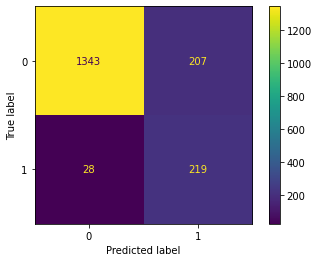

In [24]:
#Confusion Matrix

print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))
plot_confusion_matrix(LR, norm_test_f, y_test)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1550
           1       0.89      0.91      0.90       247

    accuracy                           0.97      1797
   macro avg       0.94      0.95      0.94      1797
weighted avg       0.97      0.97      0.97      1797

[[1523   27]
 [  22  225]]


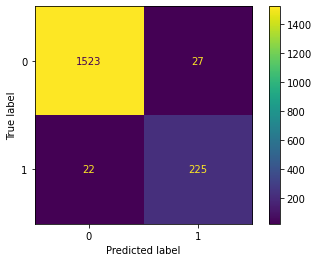

In [25]:
#Random Forest method

RF = RandomForestClassifier(random_state=42)
RF.fit(x_tr_resample, y_tr_resample)
preds_RF = RF.predict(norm_test_f)

#Confusion Matrix
print(classification_report(y_test, preds_RF))
print(confusion_matrix(y_test, preds_RF))
plot_confusion_matrix(RF, norm_test_f, y_test)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1550
           1       0.78      0.91      0.84       247

    accuracy                           0.95      1797
   macro avg       0.88      0.94      0.91      1797
weighted avg       0.96      0.95      0.95      1797

[[1487   63]
 [  22  225]]


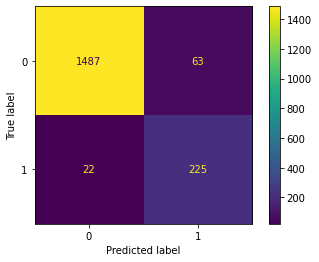

In [26]:
#XGB Classifier method

xgb_c = xgb.XGBClassifier(random_state=42)
xgb_c.fit(x_tr_resample, y_tr_resample)
preds_xgb = xgb_c.predict(norm_test_f)

#Confusion Matrix
print(classification_report(y_test, preds_xgb))
print(confusion_matrix(y_test, preds_xgb))
plot_confusion_matrix(xgb_c, norm_test_f, y_test)

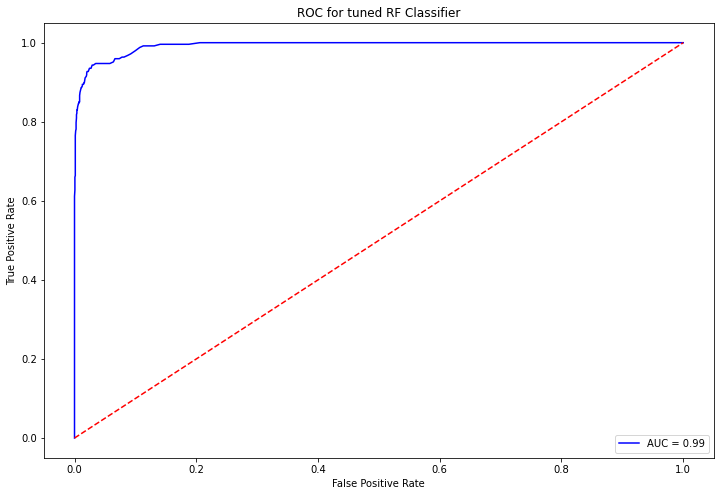

In [35]:
# Plotting AUC for tuned RF Classifier
probs = RF.predict_proba(norm_test_f)
pred = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,8))
plt.title('ROC for tuned RF Classifier')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()